# Extract Keyword list

In [12]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os

In [13]:
import sys
sys.path.append('../../src')
from DataHandler import DataHandler

In [14]:
dataHandler = DataHandler("../config.yaml")

In [15]:
df_aimeta = dataHandler.load_data("files.df_aimeta")
df_aimeta.head(3)

/media/sz/Data/Connected_Lecturers/Opal_transfer/raw/OPAL_ai_meta.p


,pipe:ID,pipe:file_type,ai:author,ai:revisedAuthor,ai:affilation,ai:title,ai:type,ai:keywords_ext,ai:keywords_gen,ai:keywords_dnb,...,ai:keywords_dnb_ids,ai:keywords_ext_ids_valid,ai:keywords_ext_valid_ratio,ai:keywords_dnb_ids_valid,ai:keywords_dnb_valid_ratio,ai:keywords_gen_ids_valid,ai:keywords_gen_valid_ratio,all_ddc_valid_ids,ddc_valid_count,valid_ddc_keywords
0,8I6sM5zapD60,pdf,"Stephan Gerhold, Marcel Beyer",[Vorname='Stephan' Familienname='Gerhold' Tite...,,Übung 3 Photogrammetrie,Aufgabenblatt,"Photogrammetrie, digitale Entzerrung, Resampli...","Photogrammetrie, digitale Entzerrung, Resampli...","Photogrammetrie, Bildverarbeitung, Digitale En...",...,"[0, 1, 2, 9, 11, 12, 14, 15, 16, 17, 18]","[0, 1, 4, 14]",0.333333,"[0, 1, 11, 12, 14, 16]",0.545455,"[0, 1, 4, 11, 12, 14]",0.545455,"[0, 1, 4, 14, 0, 1, 11, 12, 14, 16, 0, 1, 4, 1...",16,"[Photogrammetrie, digitale Entzerrung, Paralle..."
1,8ZICOHBmAHyQ,pdf,Keine Angabe.,[],,3.1 Grundlagen der Tragwerke,Skript,"Tragwerke, Lagerreaktionen, Gleichgewichtsbedi...","Tragwerke, Lagerreaktionen, Gleichgewichtsbedi...","Statik, Tragwerke, Mechanik, Festigkeitslehre,...",...,"[34, 35, 36, 37, 38, 19, 20, 21, 22, 9079, 24]","[19, 24, 27, 28]",0.363636,"[34, 35, 36, 37, 38, 19, 24]",0.636364,"[33, 19, 27, 30]",0.363636,"[19, 24, 27, 28, 34, 35, 36, 37, 38, 19, 24, 3...",15,"[Tragwerke, Festigkeitslehre, Freiheitsgrade, ..."
2,8Lfz8SAKa6k0,pdf,Robert Ringel,[Vorname='Robert' Familienname='Ringel' Titel=''],,Gedanken und Notizen zu unserem Mini-KI-Worksh...,Protokoll,"Künstliche Intelligenz, Automatisierung, Indus...","Künstliche Intelligenz, Automatisierung, Indus...","Künstliche Intelligenz, Automatisierung, Indus...",...,"[39, 40, 49, 52, 55, 54, 3191, 56, 3193, 58, 5...","[39, 40, 41, 42, 43, 45, 46, 47, 3191]",0.750000,"[39, 40, 49, 52, 55, 54, 3191, 56, 3193, 58, 5...",1.000000,"[39, 40, 43, 45, 47, 49, 52, 3191]",0.666667,"[39, 40, 41, 42, 43, 45, 46, 47, 3191, 39, 40,...",29,"[Künstliche Intelligenz, Automatisierung, Indu..."


In [16]:
df_keywords = dataHandler.load_data("files.df_keywordlist")
df_keywords.head(3)

/media/sz/Data/Connected_Lecturers/Opal_transfer/processed/keyword_list.p


,raw_keyword,lemma,is_gnd,gnd_link,sameAs_link,ddc_D3,perferedNames,totalItems,count,ddc_D2
0,Photogrammetrie,Photogrammetrie,True,https://d-nb.info/gnd/4184798-2,http://www.wikidata.org/entity/Q15850396,http://dewey.info/class/526.9825/,"['Terrestrische Fotogrammetrie', 'Fotogrammetr...",2.0,23,NaN
1,digitale Entzerrung,,True,https://d-nb.info/gnd/4395561-7,NaN,NaN,['Orthoprojektion'],1.0,2,NaN
2,Resamplingmethoden,Resamplingmethoden,False,NaN,NaN,NaN,NaN,NaN,3,NaN


## Preprocessing

Extrahiere die DDC IDs aus den URLs

In [17]:
# DDC-Nummern Extraktion und Validierung (optimiert)
def extract_and_validate_ddc(ddc_url):
    """
    Extrahiert und validiert DDC-Nummer aus einer URL.
    Gibt None zurück falls URL ungültig oder DDC-Nummer nicht korrekt formatiert ist.
    """
    if pd.isna(ddc_url):
        return None
    
    try:
        # Extrahiere DDC-Nummer aus URL (5. Element nach Split)
        ddc_number = ddc_url.split("/")[4]
        
        # Validiere Format: nur Ziffern und Punkte erlaubt
        if all(c.isdigit() or c == '.' for c in ddc_number):
            return ddc_number
        else:
            return None
    except (IndexError, AttributeError):
        return None

# Anwendung der optimierten Funktion auf beide DDC-Spalten
print("Extrahiere und validiere DDC-Nummern...")
df_keywords['ddc_D3_number'] = df_keywords['ddc_D3'].apply(extract_and_validate_ddc)
df_keywords['ddc_D2_number'] = df_keywords['ddc_D2'].apply(extract_and_validate_ddc)

# Kombiniere DDC-Nummern in einer Liste
df_keywords['ddc_numbers'] = df_keywords[['ddc_D3_number', 'ddc_D2_number']].apply(
    lambda row: [num for num in row if pd.notna(num)], axis=1
)

# Erstelle Labels mit Keywords und DDC-Nummern
df_keywords['ddc_label'] = df_keywords.apply(
    lambda row: [f"{row['raw_keyword']} ({num})" for num in row['ddc_numbers']], axis=1
)

print(f"DDC-Verarbeitung abgeschlossen. {len(df_keywords)} Keywords verarbeitet.")

# Zeige Ergebnisse für GND-validierte Keywords
df_keywords[df_keywords.is_gnd==True]\
    [['raw_keyword', 'perferedNames', 'ddc_D2', 'ddc_D2_number','ddc_D3', 
      'ddc_D3_number', 'ddc_numbers', 'ddc_label']].head(5)

Extrahiere und validiere DDC-Nummern...
DDC-Verarbeitung abgeschlossen. 40319 Keywords verarbeitet.


,raw_keyword,perferedNames,ddc_D2,ddc_D2_number,ddc_D3,ddc_D3_number,ddc_numbers,ddc_label
0,Photogrammetrie,"['Terrestrische Fotogrammetrie', 'Fotogrammetr...",NaN,None,http://dewey.info/class/526.9825/,526.9825,[526.9825],[Photogrammetrie (526.9825)]
1,digitale Entzerrung,['Orthoprojektion'],NaN,None,NaN,None,[],[]
4,Parallelprojektion,"['Parallelprojektion', 'Orthogonale Parallelpr...",NaN,None,NaN,None,[],[]
11,Bildverarbeitung,"['Bildverarbeitung', 'Snake <Bildverarbeitung>...",http://dewey.info/class/006.42/,006.42,NaN,None,[006.42],[Bildverarbeitung (006.42)]
12,Interpolation,"['Interpolation', 'Kergin-Interpolation', 'Her...",http://dewey.info/class/511.42/,511.42,NaN,None,[511.42],[Interpolation (511.42)]


In [18]:
# Wie viele Zeilen hat df_keywords?
print(f"Anzahl der Zeilen in df_keywords: {len(df_keywords)}")
# Wie viele Einträge haben ddc_D2_number und/ oder ddc_D2_number? Wie viele haben gar keinen DDC Wert?

ddc_d2_count = df_keywords['ddc_D2_number'].notna().sum()
ddc_d3_count = df_keywords['ddc_D3_number'].notna().sum()
ddc_both_count = df_keywords['ddc_numbers'].apply(lambda x: len(x) > 0).sum()
ddc_none_count = df_keywords['ddc_numbers'].apply(lambda x: len(x) == 0).sum()

print("=== DDC ZÄHLEN ===")
print(f"Einträge mit DDC D2: {ddc_d2_count}")
print(f"Einträge mit DDC D3: {ddc_d3_count}")
print(f"Einträge mit beiden DDCs: {ddc_both_count}")
print(f"Einträge ohne DDC: {ddc_none_count}")

Anzahl der Zeilen in df_keywords: 40319
=== DDC ZÄHLEN ===
Einträge mit DDC D2: 10093
Einträge mit DDC D3: 3945
Einträge mit beiden DDCs: 12686
Einträge ohne DDC: 27633




### df_aimeta - Analyse der DDC-Nummern

Sind diese als gültig in der Keyword-List enthalten?

In [19]:
# Keyword-Validierung und GND-Mapping
# Diese Zelle führt eine Validierung der extrahierten Keywords durch
# und erstellt Mappings zu GND-validierten Referenzen

# Schritt 1: Erstelle Mapping von Keywords zu IDs im df_keywords
print("Erstelle Keyword-zu-ID Mapping...")
keyword_to_id = {}
for idx, row in df_keywords.iterrows():
    if pd.notna(row['raw_keyword']):
        keyword = str(row['raw_keyword']).strip().lower()
        if keyword not in keyword_to_id:
            keyword_to_id[keyword] = []
        keyword_to_id[keyword].append(idx)

print(f"Keyword-Mapping erstellt: {len(keyword_to_id)} eindeutige Keywords")

# Schritt 2: Konvertiere Keyword-Strings zu ID-Listen
def parse_keywords_to_ids(keyword_string):
    """Konvertiert einen Keyword-String zu einer Liste von IDs"""
    if pd.isna(keyword_string) or keyword_string == "":
        return []
    
    # Teile Keywords auf (kommagetrennt)
    keywords = [k.strip().lower() for k in str(keyword_string).split(',')]
    ids = []
    
    for keyword in keywords:
        if keyword in keyword_to_id:
            ids.extend(keyword_to_id[keyword])
    
    return list(set(ids))  # Entferne Duplikate

# Erstelle _ids Spalten aus den Keyword-Strings
print("Konvertiere Keywords zu IDs...")
for keyword_type in ['ext', 'gen', 'dnb']:
    df_aimeta[f'ai:keywords_{keyword_type}_ids'] = df_aimeta[f'ai:keywords_{keyword_type}'].apply(parse_keywords_to_ids)

print("Keyword-zu-ID Konvertierung abgeschlossen")

# Schritt 3: Initialisierung der Validierungs-Spalten
for keyword_type in ['ext', 'dnb', 'gen']:
    if f'ai:keywords_{keyword_type}_ids_valid' not in df_aimeta.columns:
        df_aimeta[f'ai:keywords_{keyword_type}_ids_valid'] = [[] for _ in range(len(df_aimeta))]
    if f'ai:keywords_{keyword_type}_valid_ratio' not in df_aimeta.columns:
        df_aimeta[f'ai:keywords_{keyword_type}_valid_ratio'] = 0.0

# Schritt 4: Keyword-Validierung durch GND-Mapping
print("Starte GND-Validierung...")
for index, row in tqdm(df_aimeta.iterrows(), total=len(df_aimeta), desc="Validiere Keywords"):
    for keyword_type in ['ext', 'dnb', 'gen']:
        keyword_ids = row[f'ai:keywords_{keyword_type}_ids']
        valid_ids = []
        
        # Prüfe jeden Keyword-Index auf GND-Validierung
        for keyword_id in keyword_ids:
            if keyword_id < len(df_keywords):
                keyword_row = df_keywords.iloc[keyword_id]
                # Validierung basierend auf GND-Status und Preferred Names
                if (keyword_row['is_gnd'] == True and 
                    pd.notna(keyword_row['perferedNames']) and 
                    len(str(keyword_row['perferedNames']).strip()) > 0):
                    valid_ids.append(keyword_id)
        
        # Speichere validierte IDs und berechne Ratio
        df_aimeta.at[index, f'ai:keywords_{keyword_type}_ids_valid'] = valid_ids
        
        # Berechne Validierungs-Ratio
        total_keywords = len(keyword_ids)
        valid_keywords = len(valid_ids)
        ratio = valid_keywords / total_keywords if total_keywords > 0 else 0.0
        df_aimeta.at[index, f'ai:keywords_{keyword_type}_valid_ratio'] = ratio

# Schritt 5: Zusammenführung aller validierten DDC-Keywords
df_aimeta['all_ddc_valid_ids'] = df_aimeta['ai:keywords_ext_ids_valid'] + df_aimeta['ai:keywords_dnb_ids_valid'] + df_aimeta['ai:keywords_gen_ids_valid']
#df_aimeta['all_ddc_valid_ids'] = df_aimeta['ai:keywords_dnb_ids_valid']

# Duplikate entfernen
#df_aimeta['all_ddc_valid_ids'] = df_aimeta['all_ddc_valid_ids'].apply(lambda x: list(set(x)))

# Anzahl der validierten Keywords zählen
df_aimeta['ddc_valid_count'] = df_aimeta['all_ddc_valid_ids'].apply(lambda x: len(x))

print("Validierung abgeschlossen!")

# Ausgabe der Ergebnisse
df_aimeta[['pipe:ID',
       'ai:keywords_ext_ids_valid', 'ai:keywords_ext_valid_ratio',
       'ai:keywords_dnb_ids_valid', 'ai:keywords_dnb_valid_ratio',
       'ai:keywords_gen_ids_valid', 'ai:keywords_gen_valid_ratio', 
       "all_ddc_valid_ids", "ddc_valid_count"]].head(3)

Erstelle Keyword-zu-ID Mapping...
Keyword-Mapping erstellt: 39284 eindeutige Keywords
Konvertiere Keywords zu IDs...
Keyword-zu-ID Konvertierung abgeschlossen
Starte GND-Validierung...


Validiere Keywords: 100%|██████████| 4548/4548 [00:06<00:00, 740.83it/s]

Validierung abgeschlossen!


,pipe:ID,ai:keywords_ext_ids_valid,ai:keywords_ext_valid_ratio,ai:keywords_dnb_ids_valid,ai:keywords_dnb_valid_ratio,ai:keywords_gen_ids_valid,ai:keywords_gen_valid_ratio,all_ddc_valid_ids,ddc_valid_count
0,8I6sM5zapD60,"[0, 1, 4, 14]",0.333333,"[0, 1, 11, 12, 14, 16]",0.545455,"[0, 1, 4, 11, 12, 14]",0.545455,"[0, 1, 4, 14, 0, 1, 11, 12, 14, 16, 0, 1, 4, 1...",16
1,8ZICOHBmAHyQ,"[19, 24, 27, 28]",0.363636,"[34, 35, 36, 37, 38, 19, 24]",0.636364,"[33, 19, 27, 30]",0.363636,"[19, 24, 27, 28, 34, 35, 36, 37, 38, 19, 24, 3...",15
2,8Lfz8SAKa6k0,"[39, 40, 41, 42, 43, 45, 46, 47, 3191]",0.750000,"[39, 40, 49, 52, 55, 54, 3191, 56, 3193, 58, 5...",1.000000,"[39, 40, 43, 45, 47, 49, 52, 3191]",0.666667,"[39, 40, 41, 42, 43, 45, 46, 47, 3191, 39, 40,...",29


In [20]:
# Füge df_aimeta die gültigen Keywords aus df_keywords hinzu
df_aimeta['valid_ddc_keywords'] = df_aimeta['all_ddc_valid_ids'].apply(
    lambda ids: [df_keywords.iloc[i]['raw_keyword'] for i in ids if i < len(df_keywords)]
)
# Zeige die ersten 3 Zeilen des aktualisierten DataFrames
df_aimeta[['pipe:ID', 'valid_ddc_keywords']].head(3)

,pipe:ID,valid_ddc_keywords
0,8I6sM5zapD60,"[Photogrammetrie, digitale Entzerrung, Paralle..."
1,8ZICOHBmAHyQ,"[Tragwerke, Festigkeitslehre, Freiheitsgrade, ..."
2,8Lfz8SAKa6k0,"[Künstliche Intelligenz, Automatisierung, Indu..."


In [21]:
# speichere den aktualisierten DataFrame
dataHandler.save_data(df_aimeta, "files.df_aimeta")

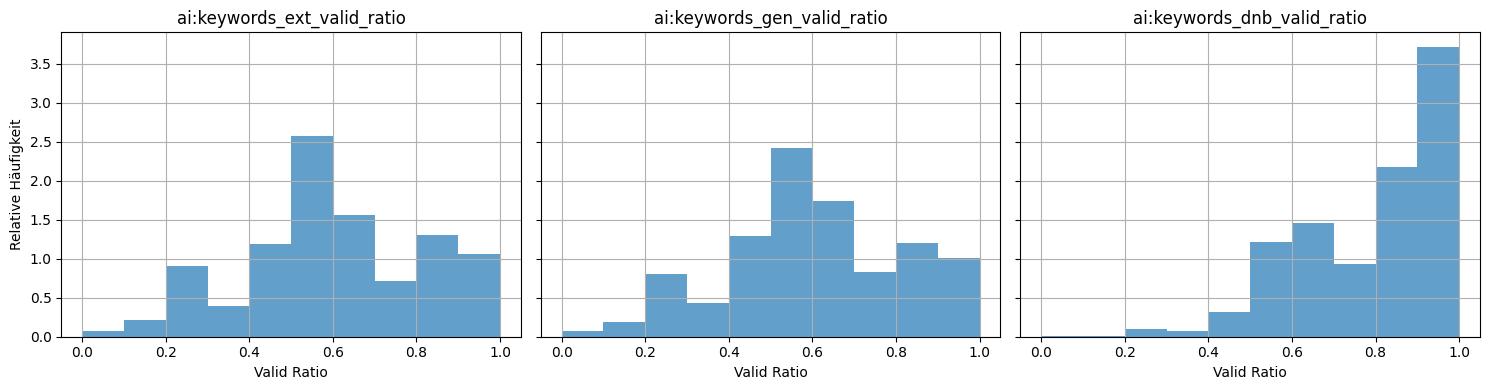

In [22]:
# Liste der Spalten für die Histogramme
columns_to_plot = [
    'ai:keywords_ext_valid_ratio',
    'ai:keywords_gen_valid_ratio', 
    'ai:keywords_dnb_valid_ratio'
]

# Erstelle Subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Erstelle Histogramme mit relativen Häufigkeiten
for i, column in enumerate(columns_to_plot):
    df_aimeta[column].hist(ax=axes[i], bins=10, density=True, alpha=0.7)
    axes[i].set_title(column)
    axes[i].set_ylabel('Relative Häufigkeit' if i == 0 else '')
    axes[i].set_xlabel('Valid Ratio')

plt.tight_layout()
plt.savefig("valid_ratio_histograms.png")
plt.show()

In [23]:
# Erstelle neuen DataFrame mit DDC Labels als Integer-Werte für alle df_aimeta Materialien

def extract_ddc_numbers_as_int(keyword_ids, df_keywords, ddc_column):
    """
    Extrahiert DDC-Nummern als Integer-Werte für eine Liste von Keyword-IDs
    Behält Duplikate bei, falls sie auftreten
    """
    ddc_numbers = []  # Verwende Liste statt Set, um Duplikate zu behalten
    
    for keyword_id in keyword_ids:
        if keyword_id < len(df_keywords):
            keyword_row = df_keywords.iloc[keyword_id]
            ddc_value = keyword_row[ddc_column]
            
            if pd.notna(ddc_value):
                try:
                    # Konvertiere DDC-Nummer zu Integer (Hauptklasse)
                    ddc_int = int(float(ddc_value.split('.')[0]))
                    ddc_numbers.append(ddc_int)  # Füge hinzu ohne Duplikat-Prüfung
                except (ValueError, AttributeError, IndexError):
                    continue
    
    return ddc_numbers

print("Erstelle DataFrame mit DDC Labels als Integer-Werte...")

# Initialisiere Listen für den neuen DataFrame
material_ids = []
ddc_d2_lists = []
ddc_d3_lists = []
ddc_d2_unique_counts = []
ddc_d3_unique_counts = []
ddc_combined_lists = []

# Verarbeite jedes Material in df_aimeta
for index, row in tqdm(df_aimeta.iterrows(), total=len(df_aimeta), desc="Verarbeite Materialien"):
    material_id = row['pipe:ID']
    material_ids.append(material_id)
    
    # Sammle alle Keyword-IDs für dieses Material
    all_keyword_ids = []
    for keyword_type in ['ext', 'gen', 'dnb']:
        keyword_ids = row[f'ai:keywords_{keyword_type}_ids']
        all_keyword_ids.extend(keyword_ids)
    
    # Entferne Duplikate aus Keyword-IDs (aber behalte DDC-Duplikate)
    all_keyword_ids = list(set(all_keyword_ids))
    
    # Extrahiere DDC_D2 Nummern als Integer
    ddc_d2_ints = extract_ddc_numbers_as_int(all_keyword_ids, df_keywords, 'ddc_D2_number')
    ddc_d2_lists.append(ddc_d2_ints)
    ddc_d2_unique_counts.append(len(ddc_d2_ints))
    
    # Extrahiere DDC_D3 Nummern als Integer
    ddc_d3_ints = extract_ddc_numbers_as_int(all_keyword_ids, df_keywords, 'ddc_D3_number')
    ddc_d3_lists.append(ddc_d3_ints)
    ddc_d3_unique_counts.append(len(ddc_d3_ints))
    
    # Kombiniere beide Listen (behalte alle Duplikate)
    combined_ddcs = ddc_d2_ints + ddc_d3_ints
    ddc_combined_lists.append(combined_ddcs)

# Erstelle neuen DataFrame
df_ddc = pd.DataFrame({
    'pipe:ID': material_ids,
    'ddc_d2_label': ddc_d2_lists,
    'ddc_d3_label': ddc_d3_lists,
    'ddc_combined_label': ddc_combined_lists,
    'ddc_d2_count': ddc_d2_unique_counts,
    'ddc_d3_count': ddc_d3_unique_counts,
    'ddc_total_count': [len(combined) for combined in ddc_combined_lists]
})

print(f"DataFrame erstellt mit {len(df_ddc)} Materialien")

df_ddc.head(3)

Erstelle DataFrame mit DDC Labels als Integer-Werte...


Verarbeite Materialien: 100%|██████████| 4548/4548 [00:06<00:00, 712.69it/s]

DataFrame erstellt mit 4548 Materialien


,pipe:ID,ddc_d2_label,ddc_d3_label,ddc_combined_label,ddc_d2_count,ddc_d3_count,ddc_total_count
0,8I6sM5zapD60,"[6, 511]","[526, 778]","[6, 511, 526, 778]",2,2,4
1,8ZICOHBmAHyQ,"[620, 624, 620, 620]","[624, 618, 531, 531, 531]","[620, 624, 620, 620, 624, 618, 531, 531, 531]",4,5,9
2,8Lfz8SAKa6k0,"[338, 6, 6, 658, 6, 629, 153]","[338, 153, 6, 519, 6, 6]","[338, 6, 6, 658, 6, 629, 153, 338, 153, 6, 519...",7,6,13


In [24]:
dataHandler.save_data(df_ddc, "files.df_ddc")

print(f"📊 Gespeicherte Daten: {len(df_ddc)} Materialien mit DDC-Klassifikationen")
print(f"📋 Spalten: {list(df_ddc.columns)}")

ddc_file_path = dataHandler.config_manager.get("files.df_ddc")
if Path(ddc_file_path).exists():
    file_size_kb = os.path.getsize(ddc_file_path) / 1024
    print(f"📁 Dateigröße: {file_size_kb:.1f} KB")

📊 Gespeicherte Daten: 4548 Materialien mit DDC-Klassifikationen
📋 Spalten: ['pipe:ID', 'ddc_d2_label', 'ddc_d3_label', 'ddc_combined_label', 'ddc_d2_count', 'ddc_d3_count', 'ddc_total_count']
📁 Dateigröße: 512.5 KB
